In [11]:
import inspect
import numpy as np
import pandas as pd
import scipy.linalg as la
import scipy.sparse as sparse
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

In [2]:
# Construct the spatial domain.
L = 1                           # Spatial domain length.
n = 2**7 - 1                    # Spatial grid size.
x_all = np.linspace(0, L, n+2)  # Full spatial grid.
x = x_all[1:-1]                 # Interior spatial grid (where q is unknown).
dx = x[1] - x[0]                # Spatial resolution.

# Construct the temporal domain.
t0, tf = 0, 1                   # Initial and final time.
k = tf*1000 + 1                 # Temporal grid size.
t = np.linspace(t0, tf, k)      # Temporal grid.
dt = t[1] - t[0]                # Temporal resolution.

print(f"Spatial step size δx = {dx}")
print(f"Temporal step size δt = {dt}")

Spatial step size δx = 0.0078125
Temporal step size δt = 0.001


In [3]:
# Construct the full-order state matrix A.
diags = np.array([1,-2,1]) / (dx**2)
A = sparse.diags(diags, [-1,0,1], (n,n))

# Define the full-order model dx/dt = f(t,x),  x(0) = x0.
def fom(t, x):
    return A @ x

# Construct the initial condition for the training data.
q0 = x * (1 - x)

print(f"shape of A:\t{A.shape}")
print(f"shape of q0:\t{q0.shape}")

shape of A:	(127, 127)
shape of q0:	(127,)


In [4]:
# Compute snapshots by solving the full-order model with SciPy.
Q = solve_ivp(fom, [t0,tf], q0, t_eval=t, method="BDF", max_step=dt).y

print(f"shape of Q: {Q.shape}")

shape of Q: (127, 1001)


In [6]:
def plot_heat_data(Z, title, ax=None):
    """Visualize temperature data in space and time."""
    if ax is None:
        _, ax = plt.subplots(1, 1)

    # Plot a few snapshots over the spatial domain.
    sample_columns = [0, 2, 5, 10, 20, 40, 80, 160, 320]
    color = iter(plt.cm.viridis_r(np.linspace(.05, 1, len(sample_columns))))

    leftBC, rightBC = [0], [0]
    for j in sample_columns:
        q_all = np.concatenate([leftBC, Z[:,j], rightBC])
        ax.plot(x_all, q_all, color=next(color), label=fr"$q(x,t_{{{j}}})$")

    ax.set_xlim(x_all[0], x_all[-1])
    ax.set_xlabel(r"$x$")
    ax.set_ylabel(r"$q(x,t)$")
    ax.legend(loc=(1.05, .05))
    ax.set_title(title)

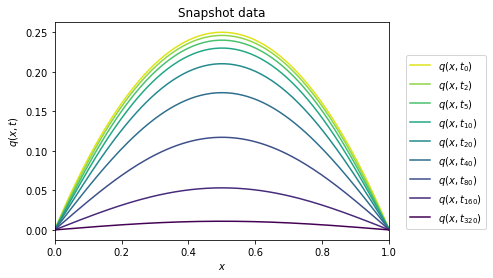

In [7]:
plot_heat_data(Q, "Snapshot data")

In [8]:
import opinf

basis = opinf.pre.PODBasis().fit(Q, r=2)                # Construct the low-dimensional basis.
Qdot = opinf.pre.ddt(Q, dt, order=6)                    # Calculate the time derivative matrix.
rom = opinf.ContinuousOpInfROM(modelform="A")           # Define the model structure.
rom.fit(basis, Q, Qdot, regularizer=1e-2)               # Construct the ROM with OpInf.
Q_ROM = rom.predict(q0, t, method="BDF", max_step=dt)   # Simulate the ROM.
opinf.post.frobenius_error(Q, Q_ROM)[1]                 # Calculate the relative error of the ROM simulation.

0.0008696280348593433

In [9]:
svdvals = la.svdvals(Q)
svdvals

array([1.47648396e+01, 1.53244669e-01, 1.25649661e-02, 2.12629402e-03,
       4.63468610e-04, 9.85497323e-05, 1.96314790e-05, 3.57655708e-06,
       6.26367098e-07, 1.07019370e-07, 1.74788283e-08, 2.45808504e-09,
       6.12112850e-10, 1.09708496e-10, 2.45976267e-11, 1.78494924e-12,
       3.60524418e-13, 9.37429462e-14, 1.25108538e-14, 1.10549569e-14,
       1.90617243e-15, 1.10229576e-15, 9.46551842e-16, 8.40071150e-16,
       7.82127501e-16, 7.41457882e-16, 6.72658784e-16, 6.30925897e-16,
       5.87431439e-16, 5.56598624e-16, 5.32854788e-16, 5.28461565e-16,
       5.01943977e-16, 4.99264202e-16, 4.71692087e-16, 4.62154938e-16,
       4.52852041e-16, 4.33529492e-16, 4.04238625e-16, 4.00562802e-16,
       3.92183307e-16, 3.89015475e-16, 3.80397890e-16, 3.70997615e-16,
       3.67177772e-16, 3.55126572e-16, 3.36297622e-16, 3.31854724e-16,
       3.31421933e-16, 3.22512617e-16, 3.15285140e-16, 3.04870913e-16,
       2.96443944e-16, 2.93074265e-16, 2.87449882e-16, 2.78123242e-16,
      

In [14]:
help(opinf.pre.svdval_decay)

Help on function svdval_decay in module opinf.pre.basis._pod:

svdval_decay(singular_values, tol=1e-08, normalize=True, plot=True, ax=None)
    Count the number of normalized singular values that are greater than
    the specified tolerance.
    
    Parameters
    ----------
    singular_values : (n,) ndarray
        Singular values of a snapshot set, e.g., scipy.linalg.svdvals(states).
    tol : float or list(float)
        Cutoff value(s) for the singular values.
    normalize : bool
        If True, normalize so that the maximum singular value is 1.
    plot : bool
        If True, plot the singular values and the cutoff value(s) against the
        singular value index.
    ax : plt.Axes or None
        Matplotlib Axes to plot the results on if plot = True.
        If not given, a new single-axes figure is created.
    
    Returns
    -------
    ranks : int or list(int)
        The number of singular values greater than the cutoff value(s).



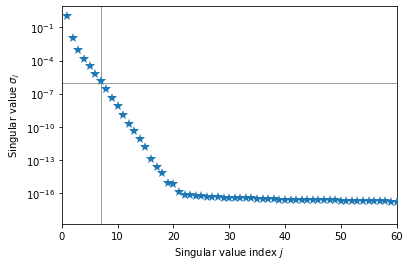

7 normalized singular values are greater than 10^(-6)


In [15]:
tolerance = 1e-6
r = opinf.pre.svdval_decay(svdvals, tol=tolerance, normalize=True, plot=True)
plt.xlim(right=60)
plt.show()
print(f"{r:d} normalized singular values are greater than 10^({int(np.log10(tolerance)):d})")

In [16]:
help(opinf.pre.cumulative_energy)

Help on function cumulative_energy in module opinf.pre.basis._pod:

cumulative_energy(singular_values, thresh=0.9999, plot=True, ax=None)
    Compute the number of singular values needed to surpass a given
    energy threshold. The energy of j singular values is defined by
    
        energy_j = sum(singular_values[:j]**2) / sum(singular_values**2).
    
    Parameters
    ----------
    singular_values : (n,) ndarray
        Singular values of a snapshot set, e.g., scipy.linalg.svdvals(states).
    thresh : float or list(float)
        Energy capture threshold(s). Default is 99.99%.
    plot : bool
        If True, plot the singular values and the cumulative energy against
        the singular value index (linear scale).
    ax : plt.Axes or None
        Matplotlib Axes to plot the results on if plot = True.
        If not given, a new single-axes figure is created.
    
    Returns
    -------
    ranks : int or list(int)
        The number of singular values required to capture mor

In [17]:
kappa = .999999
r = opinf.pre.cumulative_energy(svdvals, kappa, plot=False)
print(f"r = {r:d} singular values exceed {kappa:.4%} energy")

r = 2 singular values exceed 99.9999% energy


In [18]:
help(opinf.pre.pod_basis)

Help on function pod_basis in module opinf.pre.basis._pod:

pod_basis(states, r=None, mode='dense', return_W=False, **options)
    Compute the POD basis of rank r corresponding to the states.
    
    Parameters
    ----------
    states : (n, k) ndarray
        Matrix of k snapshots. Each column is a single snapshot of dimension n.
    r : int or None
        Number of POD basis vectors and singular values to compute.
        If None (default), compute the full SVD.
    mode : str
        Strategy to use for computing the truncated SVD of the states. Options:
        * "dense" (default): Use scipy.linalg.svd() to compute the SVD.
            May be inefficient for very large matrices.
        * "sparse": Use scipy.sparse.linalg.svds() to compute the SVD.
            This uses ARPACK for the eigensolver. Inefficient for non-sparse
            matrices; requires separate computations for full SVD.
        * "randomized": Compute an approximate SVD with a randomized approach
            

In [19]:
r = 2
Vr, _ = opinf.pre.pod_basis(Q, r, mode="dense")
print(f"Shape of Vr: {Vr.shape}")

Shape of Vr: (127, 2)


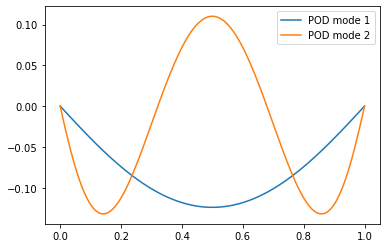

In [20]:
for j in range(Vr.shape[1]):
    plt.plot(x_all, np.concatenate(([0], Vr[:,j], [0])), label=f"POD mode {j+1}")
plt.legend(loc="upper right")
plt.show()

In [21]:
Qdot = A @ Q

print(f"Shape of Q:\t{Q.shape}")
print(f"Shape of Qdot:\t{Qdot.shape}")

Shape of Q:	(127, 1001)
Shape of Qdot:	(127, 1001)


In [22]:
help(opinf.pre.ddt_uniform)

Help on function ddt_uniform in module opinf.pre._finite_difference:

ddt_uniform(states, dt, order=2)
    Approximate the time derivatives for a chunk of snapshots that are
    uniformly spaced in time.
    
    Parameters
    ----------
    states : (n, k) ndarray
        States to estimate the derivative of. The jth column is a snapshot
        that corresponds to the jth time step, i.e., states[:, j] = x(t[j]).
    dt : float
        The time step between the snapshots, i.e., t[j+1] - t[j] = dt.
    order : int {2, 4, 6}
        The order of the derivative approximation.
        See https://en.wikipedia.org/wiki/Finite_difference_coefficient.
    
    Returns
    -------
    ddts : (n, k) ndarray
        Approximate time derivative of the snapshot data. The jth column is
        the derivative dx / dt corresponding to the jth snapshot, states[:, j].



In [23]:
Qdot2 = opinf.pre.ddt_uniform(Q, dt, order=6)

# Check that the estimate is close to the true time derivatives.
la.norm(Qdot - Qdot2, ord=np.inf) / la.norm(Qdot, ord=np.inf)

0.004828333945495823

In [24]:
Q_ = Vr.T @ Q                                   # Project the state snapshots.
Qdot_ = opinf.pre.ddt_uniform(Q_, dt, order=6)  # Estimate the projected time derivatives.

np.allclose(Vr.T @ Qdot2, Qdot_)                # Same as project the full-order time derivatives.

True

In [25]:
rom = opinf.ContinuousOpInfROM("A")
rom

Reduced-order model structure: dq / dt = Aq(t)

In [26]:
help(rom.fit)

Help on method fit in module opinf.core.nonparametric._public:

fit(basis, states, ddts, inputs=None, regularizer=0, known_operators=None) method of opinf.core.nonparametric._public.ContinuousOpInfROM instance
    Learn the reduced-order model operators from data.
    
    Parameters
    ----------
    basis : (n, r) ndarray or None
        Basis for the reduced state space (e.g., POD basis matrix).
        If None, states and ddts are assumed to already be projected.
    states : (n, k) or (r, k) ndarray
        Column-wise snapshot training data (each column is a snapshot),
        either full order (n rows) or projected to reduced order (r rows).
    ddts : (n, k) or (r, k) ndarray
        Column-wise time derivative training data (each column is a
        snapshot), either full order (n rows) or projected to reduced
        order (r rows).
    inputs : (m, k) or (k,) ndarray or None
        Column-wise inputs corresponding to the snapshots. May be
        one-dimensional if m=1 (sc

In [27]:
rom.fit(basis=Vr, states=Q, ddts=Qdot)

Reduced-order model structure: dq / dt = Aq(t)
Full-order dimension    n = 127
Reduced-order dimension r = 2

In [28]:
rom.A_.entries

array([[ -9.87391706,  -0.62759116],
       [ -0.62759116, -92.60740536]])

In [29]:
A_intrusive = Vr.T @ A @ Vr
A_intrusive

array([[ -9.87391706,  -0.62759116],
       [ -0.62759116, -92.60740536]])

In [30]:
np.allclose(rom.A_.entries, A_intrusive)

True

In [31]:
rom.fit(Vr, Q, Qdot, regularizer=1e-2)
rom.A_.entries

array([[ -9.87391253,  -0.62493006],
       [ -0.62759087, -92.2147337 ]])

In [32]:
np.allclose(rom.A_.entries, A_intrusive)

False

In [33]:
help(rom.predict)

Help on method predict in module opinf.core.nonparametric._public:

predict(state0, t, input_func=None, decode=True, **options) method of opinf.core.nonparametric._public.ContinuousOpInfROM instance
    Simulate the learned ROM with scipy.integrate.solve_ivp().
    
    Parameters
    ----------
    state0 : (n,) or (r,) ndarray
        Initial state vector, either full order (n-vector) or projected
        to reduced order (r-vector).
    t : (nt,) ndarray
        Time domain over which to integrate the reduced-order model.
    input_func : callable or (m, nt) ndarray
        Input as a function of time (preferred) or the input at the
        times `t`. If given as an array, cubic spline interpolation
        on the known data points is used as needed.
    decode : bool
        If True and the basis is not None, reconstruct the solutions
        in the original n-dimensional state space.
    options
        Arguments for scipy.integrate.solve_ivp(), such as the following:
        meth

In [34]:
Q_ROM = rom.predict(q0, t, method="BDF", max_step=dt)
Q_ROM.shape

(127, 1001)

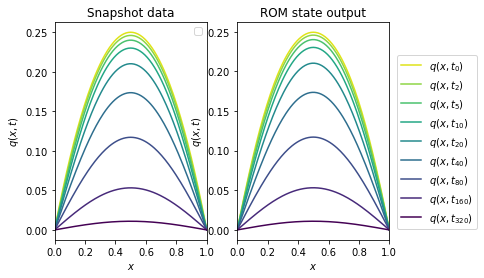

In [35]:
fig, [ax1, ax2] = plt.subplots(1, 2)
plot_heat_data(Q, "Snapshot data", ax1)
plot_heat_data(Q_ROM, "ROM state output", ax2)
ax1.legend([])
plt.show()

In [36]:
help(opinf.post.lp_error)

Help on function lp_error in module opinf.post._errors:

lp_error(Qtrue, Qapprox, p=2, normalize=False)
    Compute the absolute and relative lp-norm errors between the snapshot
    sets Qtrue and Qapprox, where Qapprox approximates to Qtrue:
    
        absolute_error_j = ||Qtrue_j - Qapprox_j||_p,
        relative_error_j = ||Qtrue_j - Qapprox_j||_p / ||Qtrue_j||_p.
    
    Parameters
    ----------
    Qtrue : (n, k) or (n,) ndarray
        "True" data. Each column is one snapshot, i.e., Qtrue[:, j] is the data
        at some time t[j]. If one-dimensional, all of Qtrue is a single
        snapshot.
    Qapprox : (n, k) or (n,) ndarray
        An approximation to Qtrue, i.e., Qapprox[:, j] approximates Qtrue[:, j]
        and corresponds to some time t[j]. If one-dimensional, all of Qapprox
        is a single snapshot approximation.
    p : float
        Order of the lp norm (default p=2 is the Euclidean norm). Used as
        the `ord` argument for scipy.linalg.norm(); see optio

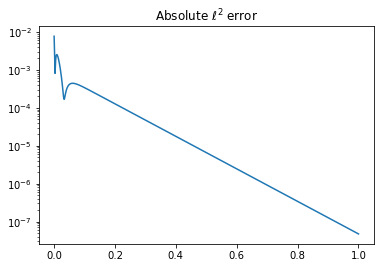

In [37]:
abs_l2err, rel_l2err = opinf.post.lp_error(Q, Q_ROM)
plt.semilogy(t, abs_l2err)
plt.title(r"Absolute $\ell^{2}$ error")
plt.show()

In [38]:
help(opinf.post.frobenius_error)

Help on function frobenius_error in module opinf.post._errors:

frobenius_error(Qtrue, Qapprox)
    Compute the absolute and relative Frobenius-norm errors between the
    snapshot sets Qtrue and Qapprox, where Qapprox approximates Qtrue:
    
        absolute_error = ||Qtrue - Qapprox||_F,
        relative_error = ||Qtrue - Qapprox||_F / ||Qtrue||_F.
    
    Parameters
    ----------
    Qtrue : (n, k)
        "True" data. Each column is one snapshot, i.e., Qtrue[:, j] is the data
        at some time t[j].
    Qapprox : (n, k)
        An approximation to Qtrue, i.e., Qapprox[:, j] approximates Qtrue[:, j]
        and corresponds to some time t[j].
    
    Returns
    -------
    abs_err : float
        Absolute error ||Qtrue - Qapprox||_F.
    rel_err : float
        Relative error ||Qtrue - Qapprox||_F / ||Qtrue||_F.



In [39]:
abs_froerr, rel_froerr = opinf.post.frobenius_error(Q, Q_ROM)
print(f"Relative Frobenius-norm error: {rel_froerr:%}")

Relative Frobenius-norm error: 0.086992%


In [40]:
def test_new_initial_condition(q0, rom, label=None):
    """Compare full-order model and reduced-order model solutions for a given
    inititial condition.

    Parameters
    ----------
    q0 : (n,)
        Heat equation initial conditions q0(x) to be tested.
    rom : opinf.ContinuousOpInfROM
        Trained reduced-order model object.
    label : str
        LaTeX description of the initial condition being tested.
    """
    # Calculate the projection error of the new initial condition.
    rel_projerr = rom.basis.projection_error(q0, relative=True)

    # Solve the full-order model (FOM) and the reduced-order model (ROM).
    Q_FOM = solve_ivp(fom, [t0,tf], q0, t_eval=t, method="BDF", max_step=dt).y
    Q_ROM = rom.predict(q0, t, method="BDF", max_step=dt)

    # Plot the FOM and ROM solutions side by side.
    fig, [ax1, ax2] = plt.subplots(1, 2)
    plot_heat_data(Q_FOM, "Full-order model solution", ax1)
    plot_heat_data(Q_ROM, "Reduced-order model solution", ax2)
    ax1.legend([])
    if label:
        fig.suptitle(label, y=1)
    fig.tight_layout()

    # Calculate the ROM error in the Frobenius norm.
    abs_froerr, rel_froerr = opinf.post.frobenius_error(Q_FOM, Q_ROM)

    # Report results.
    plt.show()
    print(f"Relative projection error of initial condition: {rel_projerr:.2%}",
          f"Relative Frobenius-norm ROM error: {rel_froerr:.2%}", sep='\n')
    return rel_projerr, rel_froerr

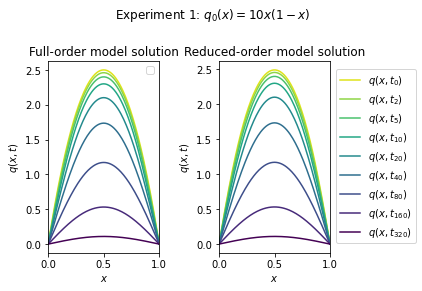

Relative projection error of initial condition: 0.37%
Relative Frobenius-norm ROM error: 0.09%


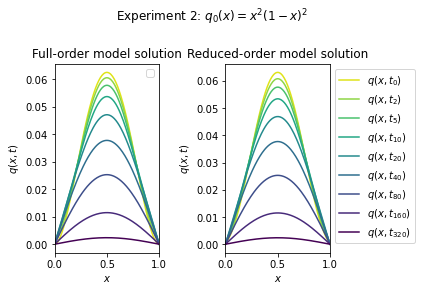

Relative projection error of initial condition: 1.63%
Relative Frobenius-norm ROM error: 0.43%


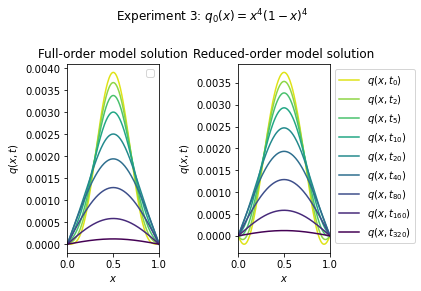

Relative projection error of initial condition: 6.19%
Relative Frobenius-norm ROM error: 2.14%


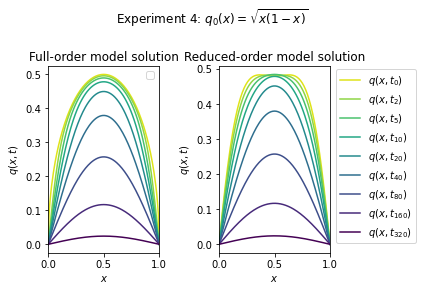

Relative projection error of initial condition: 7.80%
Relative Frobenius-norm ROM error: 1.40%


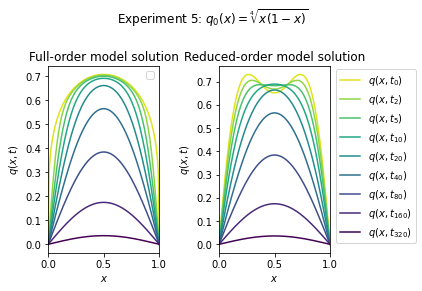

Relative projection error of initial condition: 15.36%
Relative Frobenius-norm ROM error: 2.76%


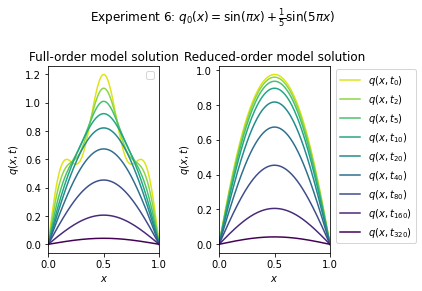

Relative projection error of initial condition: 19.45%
Relative Frobenius-norm ROM error: 4.48%


,Relative projection error of initial condition,Relative Frobenius-norm ROM error
Experiment 1,0.003719,0.000869
Experiment 2,0.016264,0.004328
Experiment 3,0.061884,0.021400
Experiment 4,0.077979,0.013968
Experiment 5,0.153560,0.027582
Experiment 6,0.194539,0.044794


In [42]:
q0_new = [
    10 * x * (1 - x),
    x**2 * (1 - x)**2,
    x**4 * (1 - x)**4,
    np.sqrt(x * (1 - x)),
    np.sqrt(np.sqrt(x * (1 - x))),
    np.sin(np.pi * x) + np.sin(5 * np.pi * x) / 5,
]

q0_titles = [
    r"$q_{0}(x) = 10 x (1 - x)$",
    r"$q_{0}(x) = x^{2} (1 - x)^{2}$",
    r"$q_{0}(x) = x^{4} (1 - x)^{4}$",
    r"$q_{0}(x) = \sqrt{x (1 - x)}$",
    r"$q_{0}(x) = \sqrt[4]{x (1 - x)}$",
    r"$q_{0}(x) = \sin(\pi x) + \frac{1}{5}\sin(5\pi x)$",
]

results = {}
for i, [q00, title] in enumerate(zip(q0_new, q0_titles)):
    results[f"Experiment {i+1:d}"] = test_new_initial_condition(q00, rom, f"Experiment {i+1}: {title}")

labels = [
    "Relative projection error of initial condition",
    "Relative Frobenius-norm ROM error"
]
pd.DataFrame(results, index=labels).T

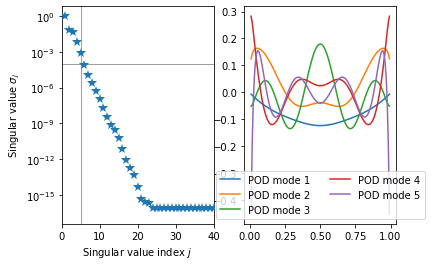

In [43]:
# Get a new, slightly larger POD basis and include the new initial conditions.
r = 5
Q_and_new_q0s = np.column_stack((Q, *q0_new))
Vr, svdvals = opinf.pre.pod_basis(Q_and_new_q0s, r, mode="dense")

# Plot the singular value decay and the first few basis vectors.
fig, [ax1, ax2] = plt.subplots(1, 2)
opinf.pre.svdval_decay(svdvals, 1e-4, plot=True, ax=ax1)
ax1.set_xlim(right=40)
for j in range(Vr.shape[1]):
    ax2.plot(x, Vr[:,j], label=f"POD mode {j+1}")
ax2.legend(loc="lower center", ncol=2)

plt.show()

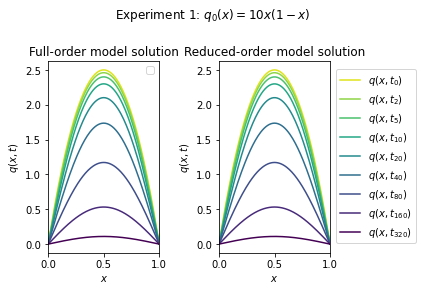

Relative projection error of initial condition: 0.00%
Relative Frobenius-norm ROM error: 0.02%


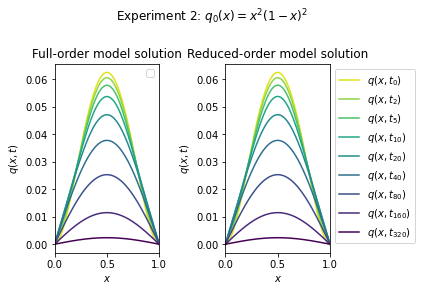

Relative projection error of initial condition: 0.02%
Relative Frobenius-norm ROM error: 0.08%


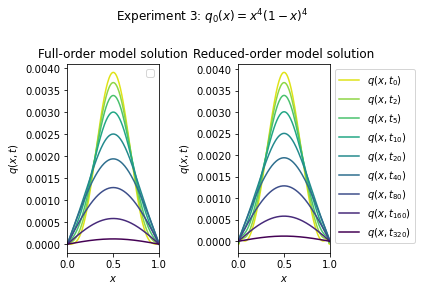

Relative projection error of initial condition: 0.96%
Relative Frobenius-norm ROM error: 0.32%


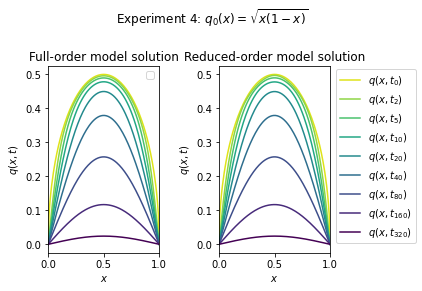

Relative projection error of initial condition: 0.01%
Relative Frobenius-norm ROM error: 0.12%


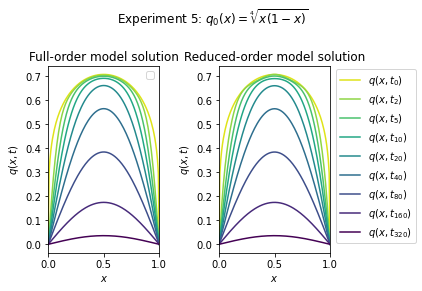

Relative projection error of initial condition: 0.00%
Relative Frobenius-norm ROM error: 0.22%


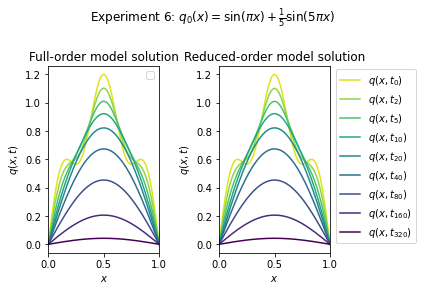

Relative projection error of initial condition: 0.00%
Relative Frobenius-norm ROM error: 0.12%


,Relative projection error of initial condition,Relative Frobenius-norm ROM error
Experiment 1,0.000031,0.000153
Experiment 2,0.000157,0.000764
Experiment 3,0.009561,0.003206
Experiment 4,0.000112,0.001186
Experiment 5,0.000018,0.002228
Experiment 6,0.000001,0.001187


In [44]:
# Learn a new ROM using the new basis
# (but only using snapshot data from one initial condition).
rom_new = opinf.ContinuousOpInfROM("A").fit(Vr, Q, Qdot)

# Repeat the experiments.
results_new = {}
for i, [q00, title] in enumerate(zip(q0_new, q0_titles)):
    results_new[f"Experiment {i+1:d}"] = test_new_initial_condition(q00, rom_new, f"Experiment {i+1}: {title}")

# Display results summary.
pd.DataFrame(results_new, index=labels).T